## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 10: Data Preparation, Notebook 2: Eigendogs

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras_backend

from sklearn.decomposition import PCA
import seaborn as sns ; sns.set()

# Just in case the config file isn't set up as we expect
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

### The cells below produce the figures for the eigendogs discussion

In [3]:
# Show six images

def plot_six(images, titles):
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        plt.subplot(1, 6, i + 1)
        vmin, vmax = np.min(images[i]), np.max(images[i])
        plt.imshow(images[i].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [4]:
# Show twelve images

def plot_twelve(images, titles):
    plt.figure(figsize=(9, 5))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        vmin, vmax = np.min(images[i]), np.max(images[i])
        plt.imshow(images[i].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(2, 6, i + 6 + 1)
        vmin, vmax = np.min(images[i+6]), np.max(images[i+6])
        plt.imshow(images[i+6].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i+6], size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
# Read in the dog pictures. Make them all the same size as the first picture
# (I think they already are), then save them in a list.

def get_input_dogs():
    # read in the dogs
    pixdir = file_helper.get_input_data_dir()
    basenames = ('husky-bw-1105338-64', 'husky-bw-1328899-64', 'husky-bw-2016708-64',
                 'husky-bw-2332240-64', 'husky-bw-2562252-64', 'husky-bw-2671006-64')

    input_dogs = []
    for i in range(len(basenames)):
        img = mpimg.imread(pixdir+'/'+basenames[i]+'.png')
        if i==0:
            img_hgt = img.shape[0]
            img_wid = img.shape[1]
        flat_img = np.reshape(img[:,:,0], [img_wid * img_hgt])
        input_dogs.append(flat_img)
    input_dogs = np.array(input_dogs)
    return input_dogs, img_wid, img_hgt

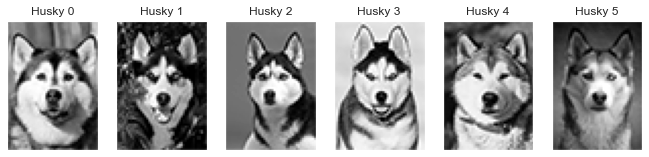

In [6]:
# show the original dogs
input_dogs, img_wid, img_hgt = get_input_dogs()

original_titles = ["Husky %d" % i for i in range(len(input_dogs))]
plot_six(input_dogs, original_titles)
file_helper.save_figure('dogs-starting')
plt.show()

In [7]:
# Augment the dataset by making lots of new dogs from the original six, 
# by shifting a little left/right and up/down, rotating a little, and
# perhaps horizontally flipping. No vertical flipping because our dogs
# aren't standing on their heads!

def generate_many_dogs(input_dogs, database_size):
    # use the input_dogs to generate a whole lot of dogs
    random_seed = 42
    np.random.seed(random_seed)
    input_dogs4D = np.reshape(input_dogs, (len(input_dogs), img_hgt, img_wid, 1))
    generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=5, horizontal_flip=True)
    generator.fit(input_dogs4D)

    dogs = []
    while len(dogs) < database_size:
        for X_batch, y_batch in generator.flow(input_dogs4D, range(len(input_dogs4D)), batch_size=32):
            for img in X_batch:
                flat_img = np.reshape(img[:,:,0], [img_wid*img_hgt])
                if len(dogs) < database_size:
                    dogs.append(flat_img)
            break
            
    return dogs

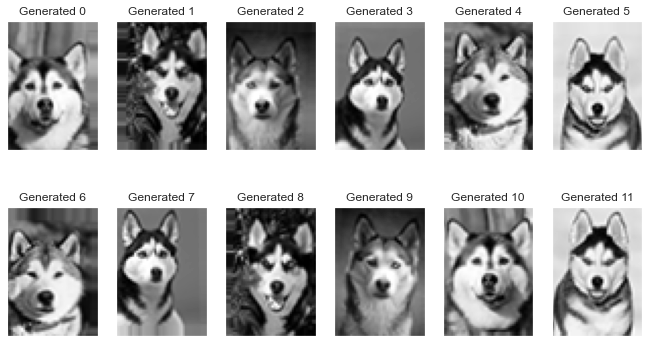

In [8]:
# How many dogs do we want to generate for training on?
training_set_size = 4000

dogs = generate_many_dogs(input_dogs, training_set_size)

original_titles = ["Generated %d" % i for i in range(len(dogs))]
plot_twelve(dogs, original_titles)
file_helper.save_figure('dogs-generated')
plt.show()

In [9]:
# Standardize the data, which makes training go faster

def standardize_dogs(dogs):
    # Standardize each feature into new variable Sdogs
    Sdogs = np.copy(dogs)
    for f in range(Sdogs.shape[1]):  # for every feature (every pixel)
        feature_center = np.mean(Sdogs[:, f])
        feature_sigma = np.sqrt(np.var(Sdogs[:, f]))
        if feature_sigma != 0:
            Sdogs[:,f] = [(v-feature_center)/feature_sigma for v in Sdogs[:, f]]
    return Sdogs

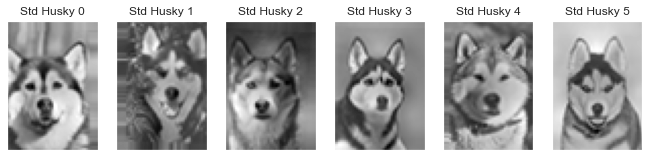

In [10]:
# Show the standardized dogs

Sdogs = standardize_dogs(dogs)

original_titles = ["Std Husky %d" % i for i in range(len(Sdogs))]
plot_six(Sdogs, original_titles)
file_helper.save_figure('dogs-standardized')
plt.show()

In [11]:
# Run PCA on the input dogs to get the eigendogs

def get_eigendogs(dogs, num_eigendogs):
    pca = PCA(n_components=num_eigendogs).fit(dogs)
    eigendogs = pca.components_.reshape((pca.components_.shape[0], img_hgt, img_wid))
    return pca, eigendogs

In [12]:
# Given PCA coefficients, and eigendog images, combine the eigendogs by weight
# to recreate a version of each input dog.

def rebuild_from_eigendogs(dogs, pca, eigendogs):
    # rebuild each dog as a combination of eigendogs
    rebuilt_dogs = []
    weights_list = []
    for i in range(len(dogs)):
        img = np.copy(dogs[i])
        img = img.reshape(1, -1)
        weights = pca.transform(img)[0]
        weights_list.append(weights)
        proj_dog = np.zeros((img_hgt, img_wid))
        for j in range(len(weights)):
            proj_dog += weights[j] * np.array(eigendogs[j])
        flat_dog = np.ravel(proj_dog)
        rebuilt_dogs.append(proj_dog)
    rebuilt_dogs = np.array(rebuilt_dogs)
    return rebuilt_dogs, weights_list

In [22]:
# Show the reconstructed dogs.

def show_rebuilds(rebuilt_dogs, weights_list, num_eigendogs):
    # Show the reguilt dogs along with their weights
    rebuilt_titles = ["Rebuild %d" % i for i in range(rebuilt_dogs.shape[0])]

    plt.figure(figsize=(9, 5))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        img_index = [0, 1, 2, 6, 7, 8][i]
        plt.subplot(2, 6, i + 1)
        img = rebuilt_dogs[i]
        vmin, vmax = np.min(img), np.max(img)
        plt.imshow(img.reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(rebuilt_titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(2, 6, i+1+6)
        plt.bar(range(len(weights_list[i])), weights_list[i], 0.75, align='center', edgecolor='black')
        plt.xticks([],[])
    title = "Reconstructions from "+str(num_eigendogs)+" eigendogs"
    plt.suptitle(title)
    file_helper.save_figure('dogs-rebuilt-'+str(num_eigendogs))
    plt.show()

In [23]:
# Rebuild all the dogs and show them

def apply_and_rebuild(dogs, num_eigendogs, save_eigendogs):
    pca, eigendogs = get_eigendogs(dogs, num_eigendogs)

    if save_eigendogs:
        eigenface_titles = ["eigendog %d" % i for i in range(eigendogs.shape[0])]
        plot_twelve(eigendogs, eigenface_titles)
        plt.suptitle("Eigendogs")
        file_helper.save_figure('eigendogs')
        plt.show()
    
    rebuilt_dogs, weights_list = rebuild_from_eigendogs(Sdogs, pca, eigendogs)
    show_rebuilds(rebuilt_dogs, weights_list, num_eigendogs)

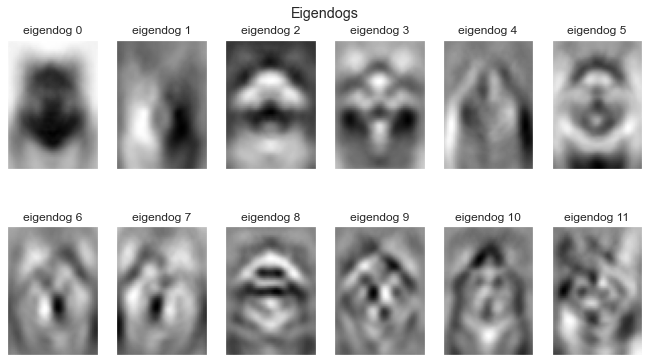

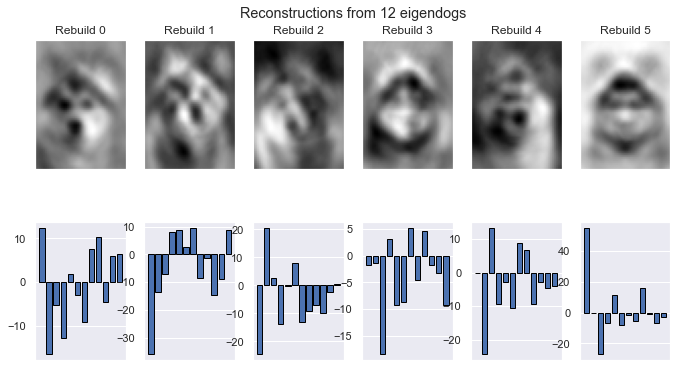

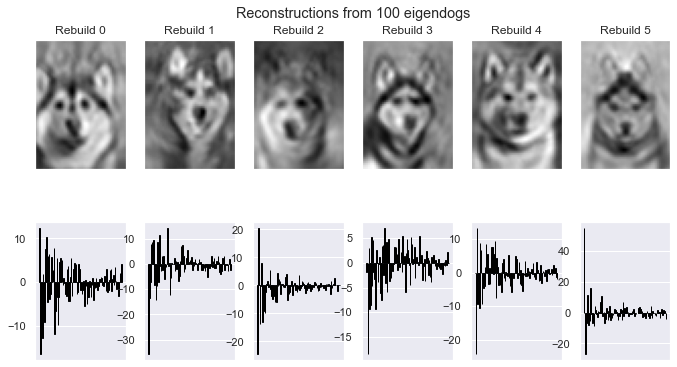

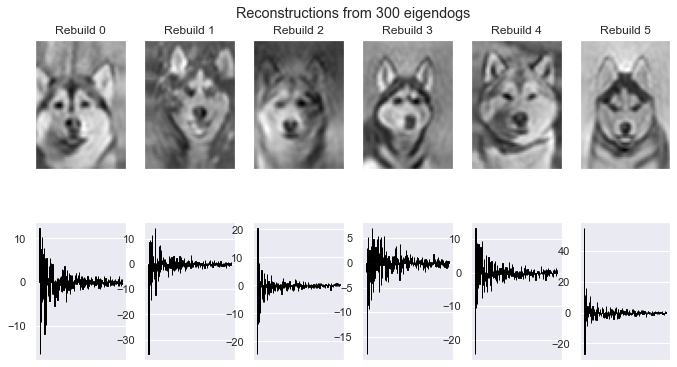

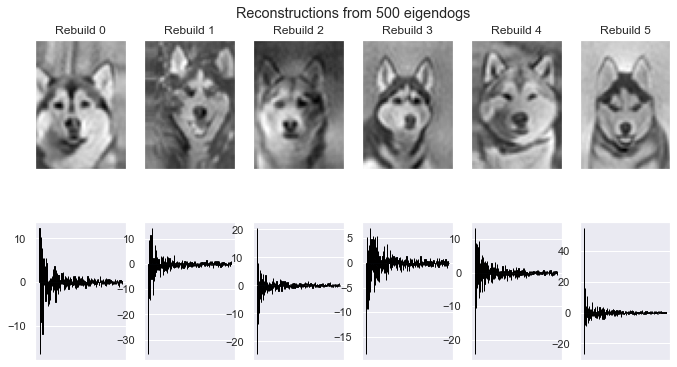

In [24]:
# Run PCA and reconstruct for different numbers of eigendogs (big numbers can take a while)

num_eigendogs = [12, 100, 300, 500]
for i in range(len(num_eigendogs)):
    apply_and_rebuild(Sdogs, num_eigendogs[i], i==0)